In [9]:
!pip install scikit-learn==1.1.3

     ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
     - -------------------------------------- 0.3/7.0 MB ? eta -:--:--
     ---- ----------------------------------- 0.8/7.0 MB 1.6 MB/s eta 0:00:04
     ------ --------------------------------- 1.0/7.0 MB 1.7 MB/s eta 0:00:04
     ------- -------------------------------- 1.3/7.0 MB 1.8 MB/s eta 0:00:04
     --------- ------------------------------ 1.6/7.0 MB 1.6 MB/s eta 0:00:04
     ------------ --------------------------- 2.1/7.0 MB 1.6 MB/s eta 0:00:04
     ------------ --------------------------- 2.1/7.0 MB 1.6 MB/s eta 0:00:04
     ------------ --------------------------- 2.1/7.0 MB 1.6 MB/s eta 0:00:04
     ------------ --------------------------- 2.1/7.0 MB 1.6 MB/s eta 0:00:04
     ------------ --------------------------- 2.1/7.0 MB 1.6 MB/s eta 0:00:04
     ---------

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\91636\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\91636\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\91636\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\91636\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^

Root Mean Squared Error (RMSE): 31287.59
R² Score: 0.8724


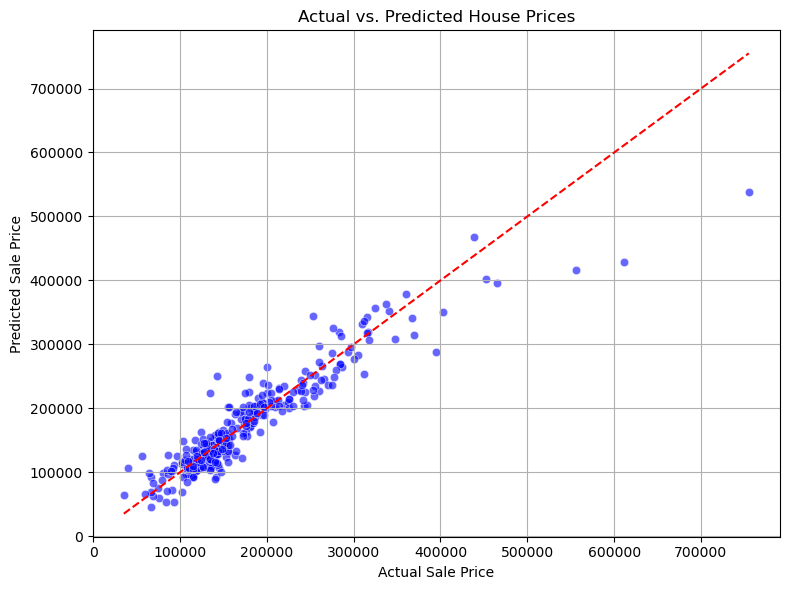

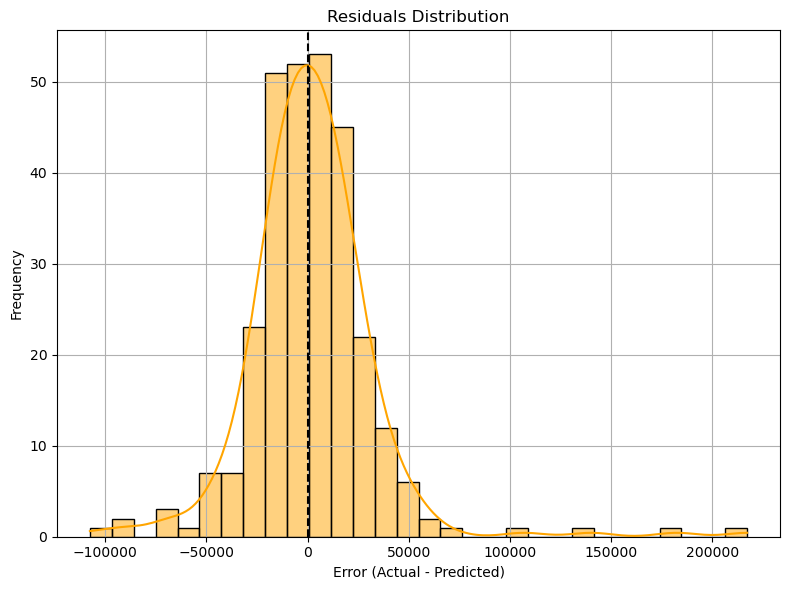

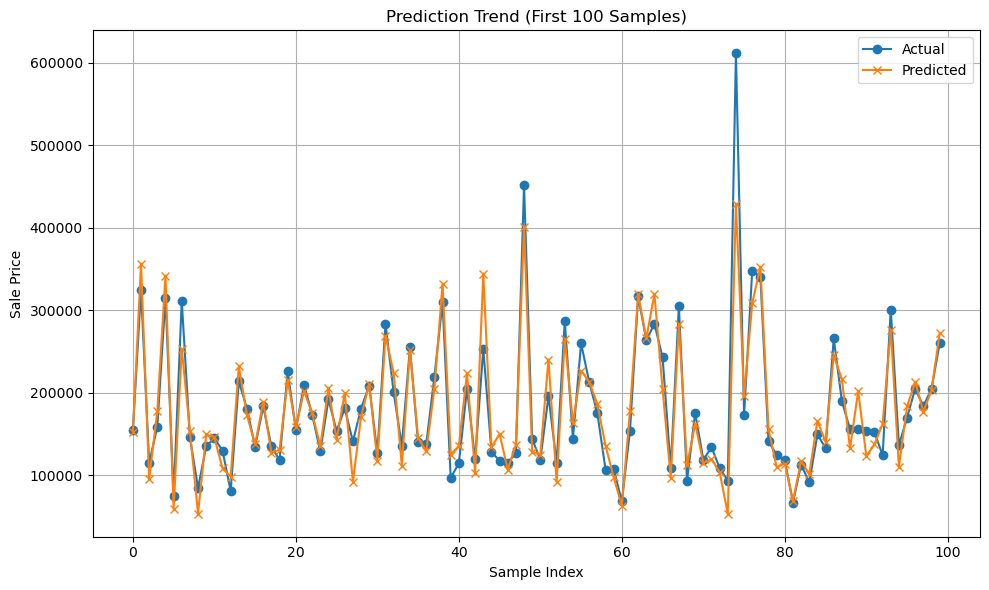

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load training data
train_df = pd.read_csv(r"C:\Users\91636\Downloads\datahouse\train.csv")

# Separate features and target
X = train_df.drop(['Id', 'SalePrice'], axis=1)
y = train_df['SalePrice']

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Preprocessing for numeric and categorical data
num_transformer = SimpleImputer(strategy='median')
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer for preprocessing
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# -----------------------------
# 📊 Visualization
# -----------------------------

# Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred, color='blue', alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted House Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.axvline(0, color='black', linestyle='--')
plt.title('Residuals Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot predicted prices trend vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_val.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Prediction Trend (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Sale Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
import joblib

# Save the trained pipeline
joblib.dump(model, "house_price_model.pkl")
print("Model saved as 'house_price_model.pkl'")


Model saved as 'house_price_model.pkl'


In [17]:
import gradio as gr
import pandas as pd
import joblib

# Load the saved model
model = joblib.load("house_price_model.pkl")

# Define a function that takes inputs and predicts price
def predict_price(MSSubClass, LotArea, OverallQual, OverallCond, YearBuilt, GrLivArea, GarageCars):
    # Create a DataFrame with all necessary features
    # We'll use a dictionary to fill in only known columns and add NaNs for the rest
    input_dict = {
        "MSSubClass": MSSubClass,
        "LotArea": LotArea,
        "OverallQual": OverallQual,
        "OverallCond": OverallCond,
        "YearBuilt": YearBuilt,
        "GrLivArea": GrLivArea,
        "GarageCars": GarageCars,
    }

    # Create DataFrame
    input_df = pd.DataFrame([input_dict])

    # Add any missing columns with NaN (in case the model expects more)
    model_input_columns = model.named_steps['preprocessor'].feature_names_in_
    for col in model_input_columns:
        if col not in input_df.columns:
            input_df[col] = [None]

    # Reorder columns to match model expectation
    input_df = input_df[model_input_columns]

    # Predict
    prediction = model.predict(input_df)[0]
    return f"🏡 Predicted House Price: ₹{int(prediction):,}"

# Launch the Gradio interface
demo = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="MSSubClass", value=60),
        gr.Number(label="LotArea", value=8000),
        gr.Number(label="OverallQual", value=5),
        gr.Number(label="OverallCond", value=5),
        gr.Number(label="YearBuilt", value=2000),
        gr.Number(label="GrLivArea", value=1500),
        gr.Number(label="GarageCars", value=2),
    ],
    outputs=gr.Textbox(label="Predicted Sale Price"),
    title="🏡 House Price Prediction",
    description="Enter basic details to predict the house price using a trained Linear Regression model."
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
